In [6]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import swish  # available as a built-in activation in TF 2.4+
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [7]:
def preprocess_image(image_path, target_size=(128, 128)):
    # Read image with OpenCV
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    
    # Resize image
    img = cv2.resize(img, target_size)
    
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply histogram equalization to improve contrast
    img_eq = cv2.equalizeHist(img_gray)

    # Apply Gaussian blur to reduce noise (kernel size 3x3)
    img_blur = cv2.GaussianBlur(img_eq, (3, 3), 0)

    # Normalize pixel values to the range [0,1]
    img_norm = img_blur.astype("float32") / 255.0

    # Expand dims to add a channel dimension (H, W, 1)
    img_norm = np.expand_dims(img_norm, axis=-1)
    return img_norm

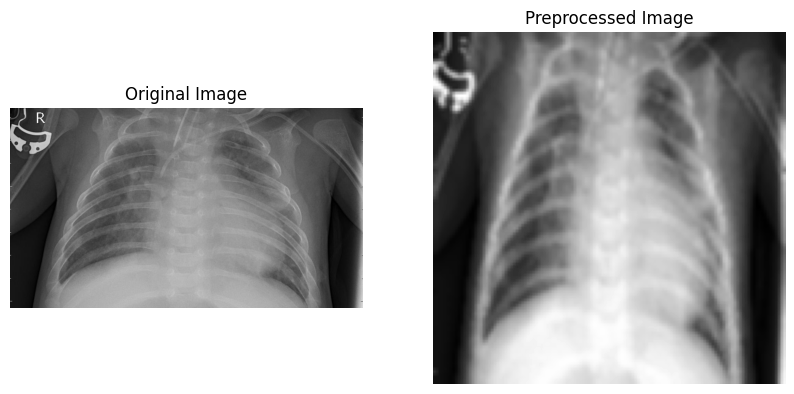

In [8]:
sample_image_path = "Lab 3 eval/chest_xray/chest_xray/test/PNEUMONIA/person1_virus_8.jpeg"
# Read the original image
import cv2
import matplotlib.pyplot as plt

original_img = cv2.imread(sample_image_path)

# Process the image
processed_img = preprocess_image(sample_image_path)

# Display input and output images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Show original image
ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis("off")

# Show processed image
ax[1].imshow(processed_img.squeeze(), cmap="gray")
ax[1].set_title("Preprocessed Image")
ax[1].axis("off")

plt.show()

In [9]:
def load_data(split_paths, target_size=(128, 128)):
    X, y = [], []
    supported_formats = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff"}
    
    # Each element in split_paths is a dictionary mapping a category to its folder path.
    for cat_dict in split_paths:
        for category, path in cat_dict.items():
            # Map categories to labels: 'normal' -> 0, 'pneumonia' -> 1
            label = 0 if category.lower() == 'normal' else 1
            # List all files in the directory
            for filename in os.listdir(path):
                ext = os.path.splitext(filename)[1].lower()
                if ext in supported_formats:
                    image_path = os.path.join(path, filename)
                    try:
                        img = preprocess_image(image_path, target_size)
                        X.append(img)
                        y.append(label)
                    except Exception as e:
                        print(f"Error processing {filename}: {e}")
    return np.array(X), np.array(y)

In [10]:
folder_path = {
    "train": [
        {"normal": "Lab 3 eval/chest_xray/chest_xray/train/NORMAL"},
        {"pneumonia": "Lab 3 eval/chest_xray/chest_xray/train/PNEUMONIA"}
    ],
    "val": [
        {"normal": "Lab 3 eval/chest_xray/chest_xray/val/NORMAL"},
        {"pneumonia": "Lab 3 eval/chest_xray/chest_xray/val/PNEUMONIA"}
    ],
    "test": [
        {"normal": "Lab 3 eval/chest_xray/chest_xray/test/NORMAL"},
        {"pneumonia": "Lab 3 eval/chest_xray/chest_xray/test/PNEUMONIA"}
    ],
}

print("Loading training data...")
X_train, y_train = load_data(folder_path["train"], target_size=(128, 128))
print("Loading validation data...")
X_val, y_val = load_data(folder_path["val"], target_size=(128, 128))
print("Loading test data...")
X_test, y_test = load_data(folder_path["test"], target_size=(128, 128))

print(f"Train set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Loading training data...
Loading validation data...
Loading test data...
Train set: 5216 images
Validation set: 16 images
Test set: 624 images


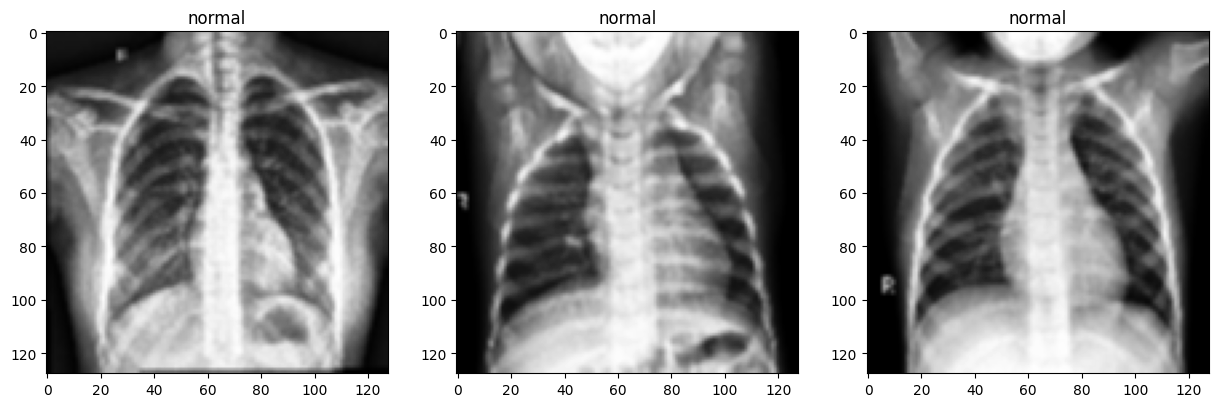

In [11]:
labels = ['normal', 'pneumonia']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(labels[y_train[i]])
plt.show()

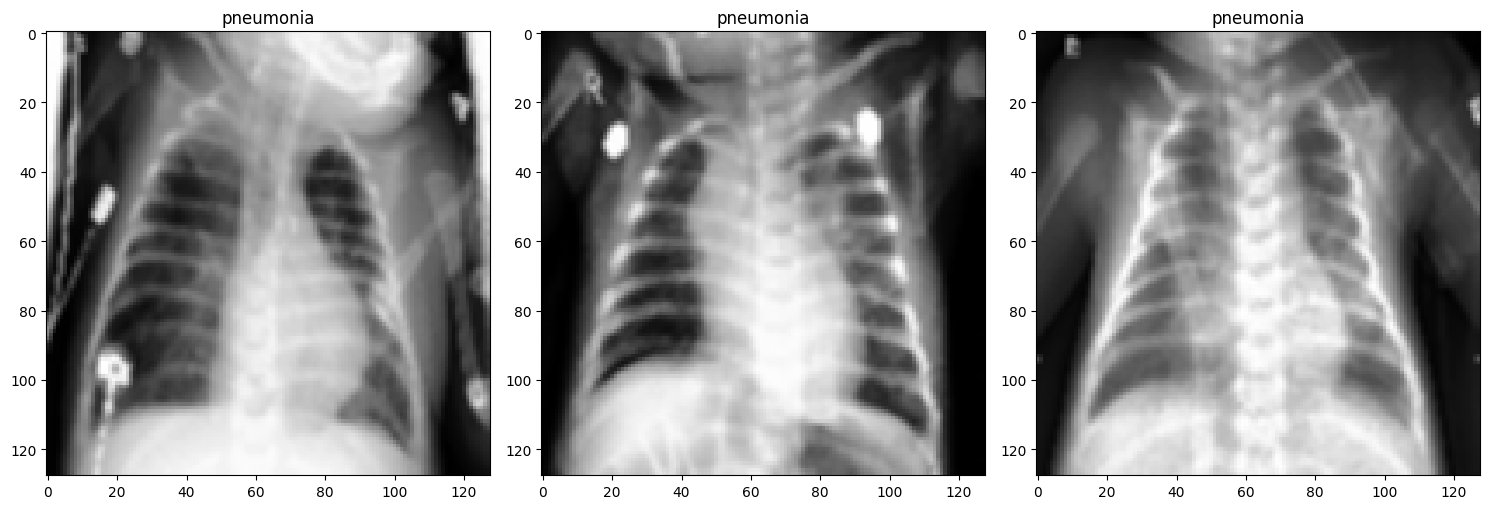

In [12]:
import matplotlib.pyplot as plt

# Define labels and figure settings
labels = ['normal', 'pneumonia']
figsize = (15, 5)
num_cols = 3

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, num_cols, figsize=figsize)

# Iterate over the subplots and display pneumonia images
for i, ax in enumerate(axs):
    idx = np.where(y_train == 1)[0][i]  # Get index of pneumonia image
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title(labels[y_train[idx]])

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()

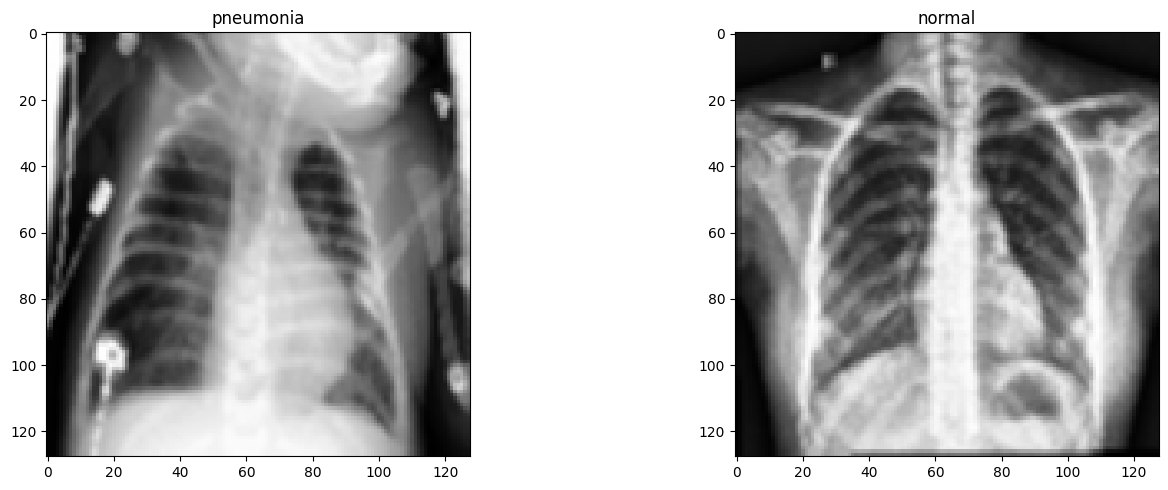

In [13]:
fig, axs = plt.subplots(1, 2, figsize=figsize)

# Get index of pneumonia image
idx_pneumonia = np.where(y_train == 1)[0][0]

# Get index of normal image
idx_normal = np.where(y_train == 0)[0][0]

# Display pneumonia image
axs[0].imshow(X_train[idx_pneumonia], cmap='gray')
axs[0].set_title(labels[y_train[idx_pneumonia]])

# Display normal image
axs[1].imshow(X_train[idx_normal], cmap='gray')
axs[1].set_title(labels[y_train[idx_normal]])

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()

/var/folders/0k/lbvs8t7s1rx9_rsngx67x2z00000gn/T/ipykernel_41498/2011833667.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train,palette="coolwarm")


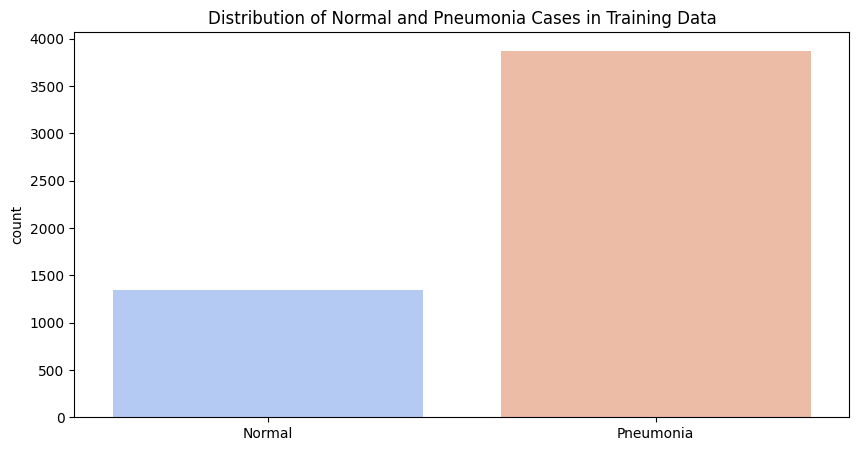

In [14]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train,palette="coolwarm")
plt.title("Distribution of Normal and Pneumonia Cases in Training Data")
plt.xticks(ticks=[0, 1], labels=["Normal", "Pneumonia"])
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

input_shape = X_train.shape[1:]  # Ensure X_train is correctly defined

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='tanh', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='swish'),  # Corrected swish activation
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Use mini-batch gradient descent via SGD optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/Users/jiveshkarthik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,233 (16.35 MB)

 Trainable params: 4,287,233 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_arr))
print("Class weights:", class_weights)

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.6959 - loss: 0.5229 - val_accuracy: 0.8750 - val_loss: 0.3922
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9201 - loss: 0.1824 - val_accuracy: 0.8125 - val_loss: 0.3419
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9434 - loss: 0.1388 - val_accuracy: 0.8750 - val_loss: 0.3419
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.9486 - loss: 0.1167 - val_accuracy: 0.7500 - val_loss: 0.3322
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9632 - loss: 0.0950 - val_accuracy: 0.8750 - val_loss: 0.2515
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9654 - loss: 0.0846 - val_accuracy: 0.9375 - val_loss: 0.2086
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9717 - loss: 0.0783 - val_accuracy: 0.8125 - val_loss: 0.4466
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9731 - loss: 0

In [18]:
y_pred = model.predict(X_test)
# Convert probabilities to binary class labels (threshold = 0.5)
y_pred_class = (y_pred > 0.5).astype("int32")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


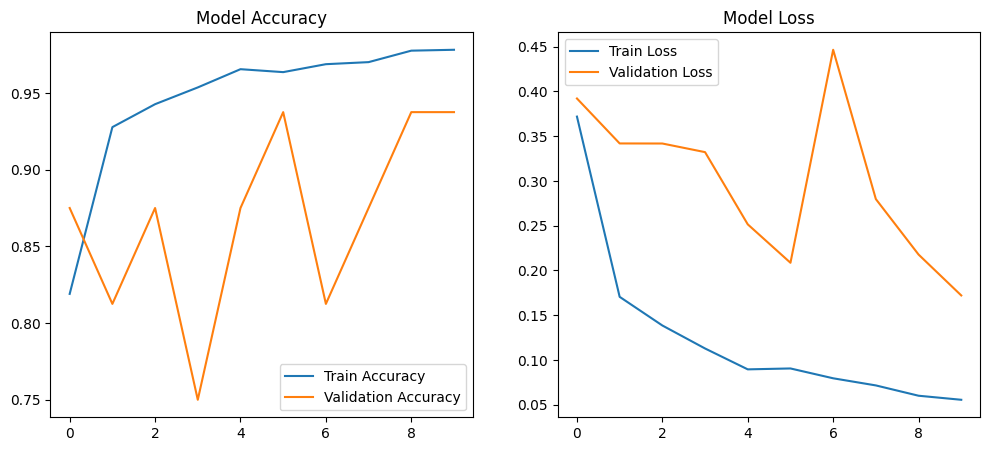

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6439 - loss: 1.5650
Test loss: 0.9014, Test accuracy: 0.8013
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.95      0.50      0.65       234
   pneumonia       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.76       624
weighted avg       0.83      0.80      0.78       624



In [19]:
# Training History Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test, y_pred_class, target_names=["normal", "pneumonia"]))

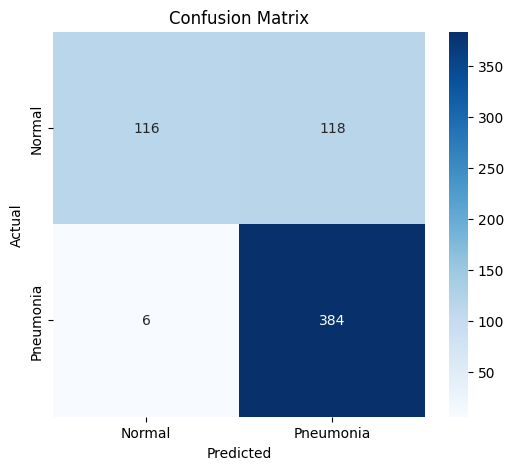

In [20]:
import seaborn as sns
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

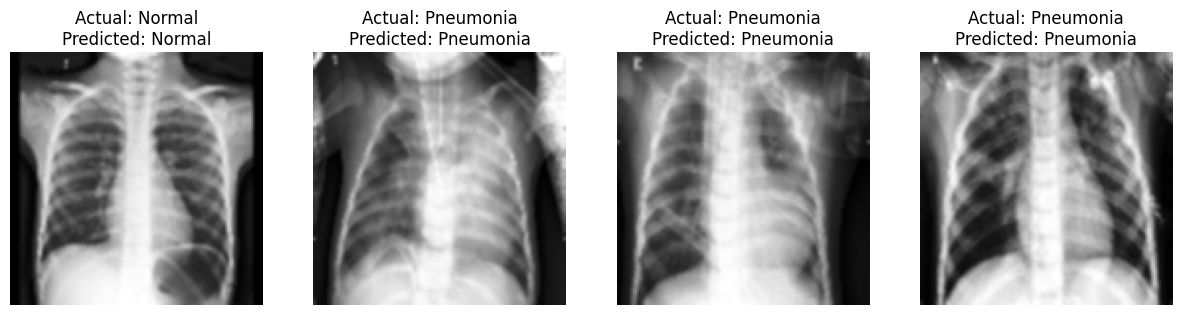

In [21]:
# Sample Predictions
def show_sample_predictions(X, y, y_pred, num_samples=4):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        index = np.random.randint(0, len(y))
        img = np.squeeze(X[index])
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {'Normal' if y[index] == 0 else 'Pneumonia'}\nPredicted: {'Normal' if y_pred[index] == 0 else 'Pneumonia'}")
        plt.axis('off')
    plt.show()

show_sample_predictions(X_test, y_test, y_pred_class)


In [22]:
model.save("pneumonia_detection_model.h5")
print("Model saved successfully.")


Model saved successfully.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6439 - loss: 1.5650
Reloaded Model Test Accuracy: 0.8013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


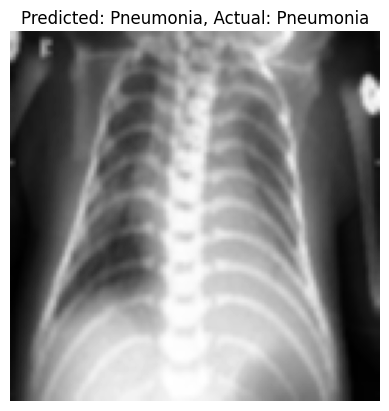

In [23]:
from tensorflow.keras.models import load_model

# Load model
loaded_model = load_model("pneumonia_detection_model.h5")

# Evaluate on test set
test_loss, test_acc = loaded_model.evaluate(X_test, y_test)
print(f"Reloaded Model Test Accuracy: {test_acc:.4f}")

# Predict on a random test image
index = np.random.randint(0, len(X_test))
sample_img = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
prediction = loaded_model.predict(sample_img)[0][0]
predicted_label = "Pneumonia" if prediction > 0.5 else "Normal"

# Display the prediction
plt.imshow(X_test[index].squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_label}, Actual: {'Pneumonia' if y_test[index] == 1 else 'Normal'}")
plt.axis("off")
plt.show()
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


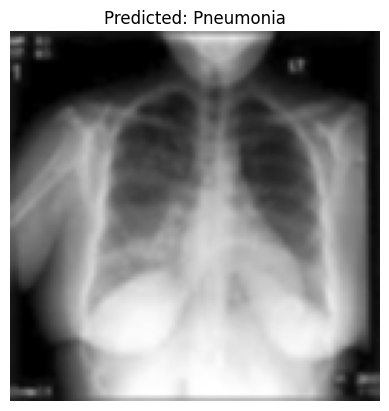

In [24]:
def predict_new_image(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)[0][0]
    predicted_label = "Pneumonia" if prediction > 0.5 else "Normal"

    # Display image with prediction
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# Test with an external image
new_image_path = "/Users/jiveshkarthik/Downloads/images (3).jpeg" 
predict_new_image(new_image_path)


(None, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


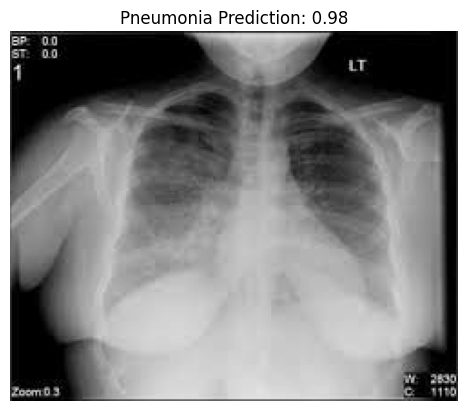

In [61]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print(model.input_shape)  # This will tell us the correct format


def preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if img is None:
        raise ValueError(f"Error: Cannot load image at {image_path}")

    img = cv2.resize(img, target_size)  # Resize to 128x128
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (H, W, 1)
    img = np.expand_dims(img, axis=0)   # Add batch dimension (1, H, W, 1)
    return img

# Load pre-trained model (Ensure correct path)
model_path = "pneumonia_detection_model.h5"  # Change this if needed
model = tf.keras.models.load_model(model_path)

# Load and preprocess a sample image
image_path = "/Users/jiveshkarthik/Downloads/images (3).jpeg"  # Replace with actual path
image = preprocess_image(image_path)

# Get model prediction
prediction = model.predict(image)

# Display result
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title(f"Pneumonia Prediction: {prediction[0][0]:.2f}")
plt.axis("off")
plt.show()
